# Unsupervised Machine Learning for the Classification of Astrophysical X-ray Sources
###### *Víctor Samuel Pérez Díaz<sup>1</sup>, Rafael Martinez-Galarza<sup>2</sup>, Alexander Caicedo-Dorado<sup>1</sup>, Raffaele D'Abrusco<sup>2</sup>*

*1. Universidad del Rosario, 2. Center for Astrophysics | Harvard & Smithsonian*

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import cm
import math
import seaborn as sns
from astropy.io.votable import parse
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Edit the font, font size, and axes width

mpl.rcParams['font.family'] = 'Avenir LT Std'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2

In [3]:
def votable_to_pandas(votable_file):
    '''
    Converts votable to pandas dataframe.
    '''
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

#### Histogram plots

Histogram plots for all features in X-ray only tables and X-ray + Optical.

In [4]:
df_newxray = votable_to_pandas('cscresults.vot')

In [5]:
powlaw_gamma_CI_per = (df_newxray['powlaw_gamma_hilim'] - df_newxray['powlaw_gamma_lolim'])/df_newxray['powlaw_gamma']
df_newxray['powlaw_gamma_CI_per'] = powlaw_gamma_CI_per

bb_kt_CI_per = (df_newxray['bb_kt_hilim'] - df_newxray['bb_kt_lolim'])/df_newxray['bb_kt']
df_newxray['bb_kt_CI_per'] = bb_kt_CI_per

df_newxray['var_ratio_b'] = df_newxray['var_sigma_b']/df_newxray['var_mean_b']
df_newxray['var_ratio_h'] = df_newxray['var_sigma_h']/df_newxray['var_mean_h']
df_newxray['var_ratio_s'] = df_newxray['var_sigma_s']/df_newxray['var_mean_s']

df_newxray['var_newq_b'] = ((df_newxray['var_max_b'] + df_newxray['var_min_b'])/2)/df_newxray['var_mean_b']
df_newxray['var_newq_h'] = ((df_newxray['var_max_h'] + df_newxray['var_min_h'])/2)/df_newxray['var_mean_h']
df_newxray['var_newq_s'] = ((df_newxray['var_max_s'] + df_newxray['var_min_s'])/2)/df_newxray['var_mean_s']

In [6]:
df_xray = pd.read_csv('gmm6_allvar_0_simbad.csv')
df_xray.drop('col1', inplace=True, axis=1)

features_xray = ['hard_hm', 'hard_hs', 'hard_ms', 'powlaw_gamma', 'powlaw_gamma_CI_per', 'bb_kt', 'bb_kt_CI_per', 'var_prob_b','var_sigma_b', 'var_mean_b', 'var_ratio_b', 'var_prob_h', 'var_sigma_h', 'var_mean_h', 'var_ratio_h', 'var_prob_s', 'var_sigma_s',
'var_mean_s', 'var_ratio_s', 'var_newq_b', 'var_newq_h', 'var_newq_s']
features_lognorm_xray = ['bb_kt', 'var_sigma_b', 'var_mean_b', 'var_sigma_h', 'var_mean_h', 'var_sigma_s', 'var_mean_s', 'var_ratio_b', 'var_ratio_h', 'var_ratio_s', 'var_newq_b', 'var_newq_h', 'var_newq_s']

df_xray_plus = df_xray.merge(df_newxray[['name', 'obsid', 'powlaw_gamma_CI_per', 'bb_kt_CI_per', 'var_ratio_b', 'var_ratio_h', 'var_ratio_s', 'var_newq_b', 'var_newq_h', 'var_newq_s']], how='left', on=['name', 'obsid'])
df_xray_plus = df_xray_plus.dropna(subset=features_xray)

In [12]:
def move_legend(ax, new_loc, **kws):
    '''https://github.com/mwaskom/seaborn/issues/2280'''
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

def hist_plots(df):
    colors = cm.get_cmap('Set1')
    
    features = features_xray

    features_lognorm = features_lognorm_xray
    
    nrow = 8; ncol = 3;
    fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(16,40))
    fig.tight_layout(h_pad=10, w_pad=2)
    for i, ax in enumerate(axs.reshape(-1)): 
        if i >= len(features):
            ax.set_axis_off()
            continue
        ax.yaxis.set_tick_params(which='major', size=6, width=0.5, direction='in')
        ax.yaxis.set_tick_params(which='minor', size=3, width=0.5, direction='in')
        ax.xaxis.set_tick_params(which='major', size=6, width=0.5, direction='out')
        ax.xaxis.set_tick_params(which='minor', size=3, width=0.5, direction='out')
        
        if features[i] in features_lognorm:
            X_desc = df[features[i]]
            nonzero = X_desc[X_desc!=0]
            minval = np.min(nonzero)/10

            df[features[i]] = X_desc + minval
            axsns = sns.histplot(data=df, x=features[i], hue='cluster', ax=ax , palette=colors, bins=40, element="step", log_scale=True, stat="probability", common_norm=False)
            ax.set_xlabel('log({})'.format(features[i]))
        elif features[i] == 'bb_kt_CI_per': 
            df_xray_prov = df[(df.bb_kt_CI_per <=2) & (df.bb_kt_CI_per >=0)]
            axsns = sns.histplot(data=df_xray_prov, x=features[i], hue='cluster', ax=ax , palette=colors, bins=40, element="step", stat="probability", common_norm=False)
        elif features[i] == 'powlaw_gamma_CI_per':
            df_xray_prov = df[(df.powlaw_gamma_CI_per <=1) & (df.powlaw_gamma_CI_per >=-1)]
            axsns = sns.histplot(data=df_xray_prov, x=features[i], hue='cluster', ax=ax , palette=colors, bins=40, element="step", stat="probability", common_norm=False)
#         elif features[i] == 'var_newq_b':
#             df_xray_prov = df[(df.var_newq_b <=4) & (df.var_newq_b >=-4)]
#             axsns = sns.histplot(data=df_xray_prov, x=features[i], hue='cluster', ax=ax , palette=colors, bins=40, element="step", stat="probability", common_norm=False)
#         elif features[i] == 'var_newq_h':
#             df_xray_prov = df[(df.var_newq_h <=4) & (df.var_newq_h >=-4)]
#             axsns = sns.histplot(data=df_xray_prov, x=features[i], hue='cluster', ax=ax , palette=colors, bins=40, element="step", stat="probability", common_norm=False)
#         elif features[i] == 'var_newq_s':
#             df_xray_prov = df[(df.var_newq_s <=4) & (df.var_newq_s >=-4)]
#             axsns = sns.histplot(data=df_xray_prov, x=features[i], hue='cluster', ax=ax , palette=colors, bins=40, element="step", stat="probability", common_norm=False)       
        else:
            axsns = sns.histplot(data=df, x=features[i], hue='cluster', ax=ax , palette=colors, bins=40, element="step", stat="probability", common_norm=False)
        axsns.set(ylabel=None)
        move_legend(ax,
            new_loc="lower center",
            bbox_to_anchor=(.5, 1), ncol=3
        )
        #ax.set_title(features[i], fontsize=12)
        

        plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
        
        #handles, labels = ax.get_legend_handles_labels()
    #fig.legend(handles, labels, bbox_to_anchor=(0.8, 1.01))
    
    plt.savefig('figures/norm_newxray_hists.pdf', dpi=300, transparent=False, bbox_inches='tight')

'AvenirLTStd-Roman.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


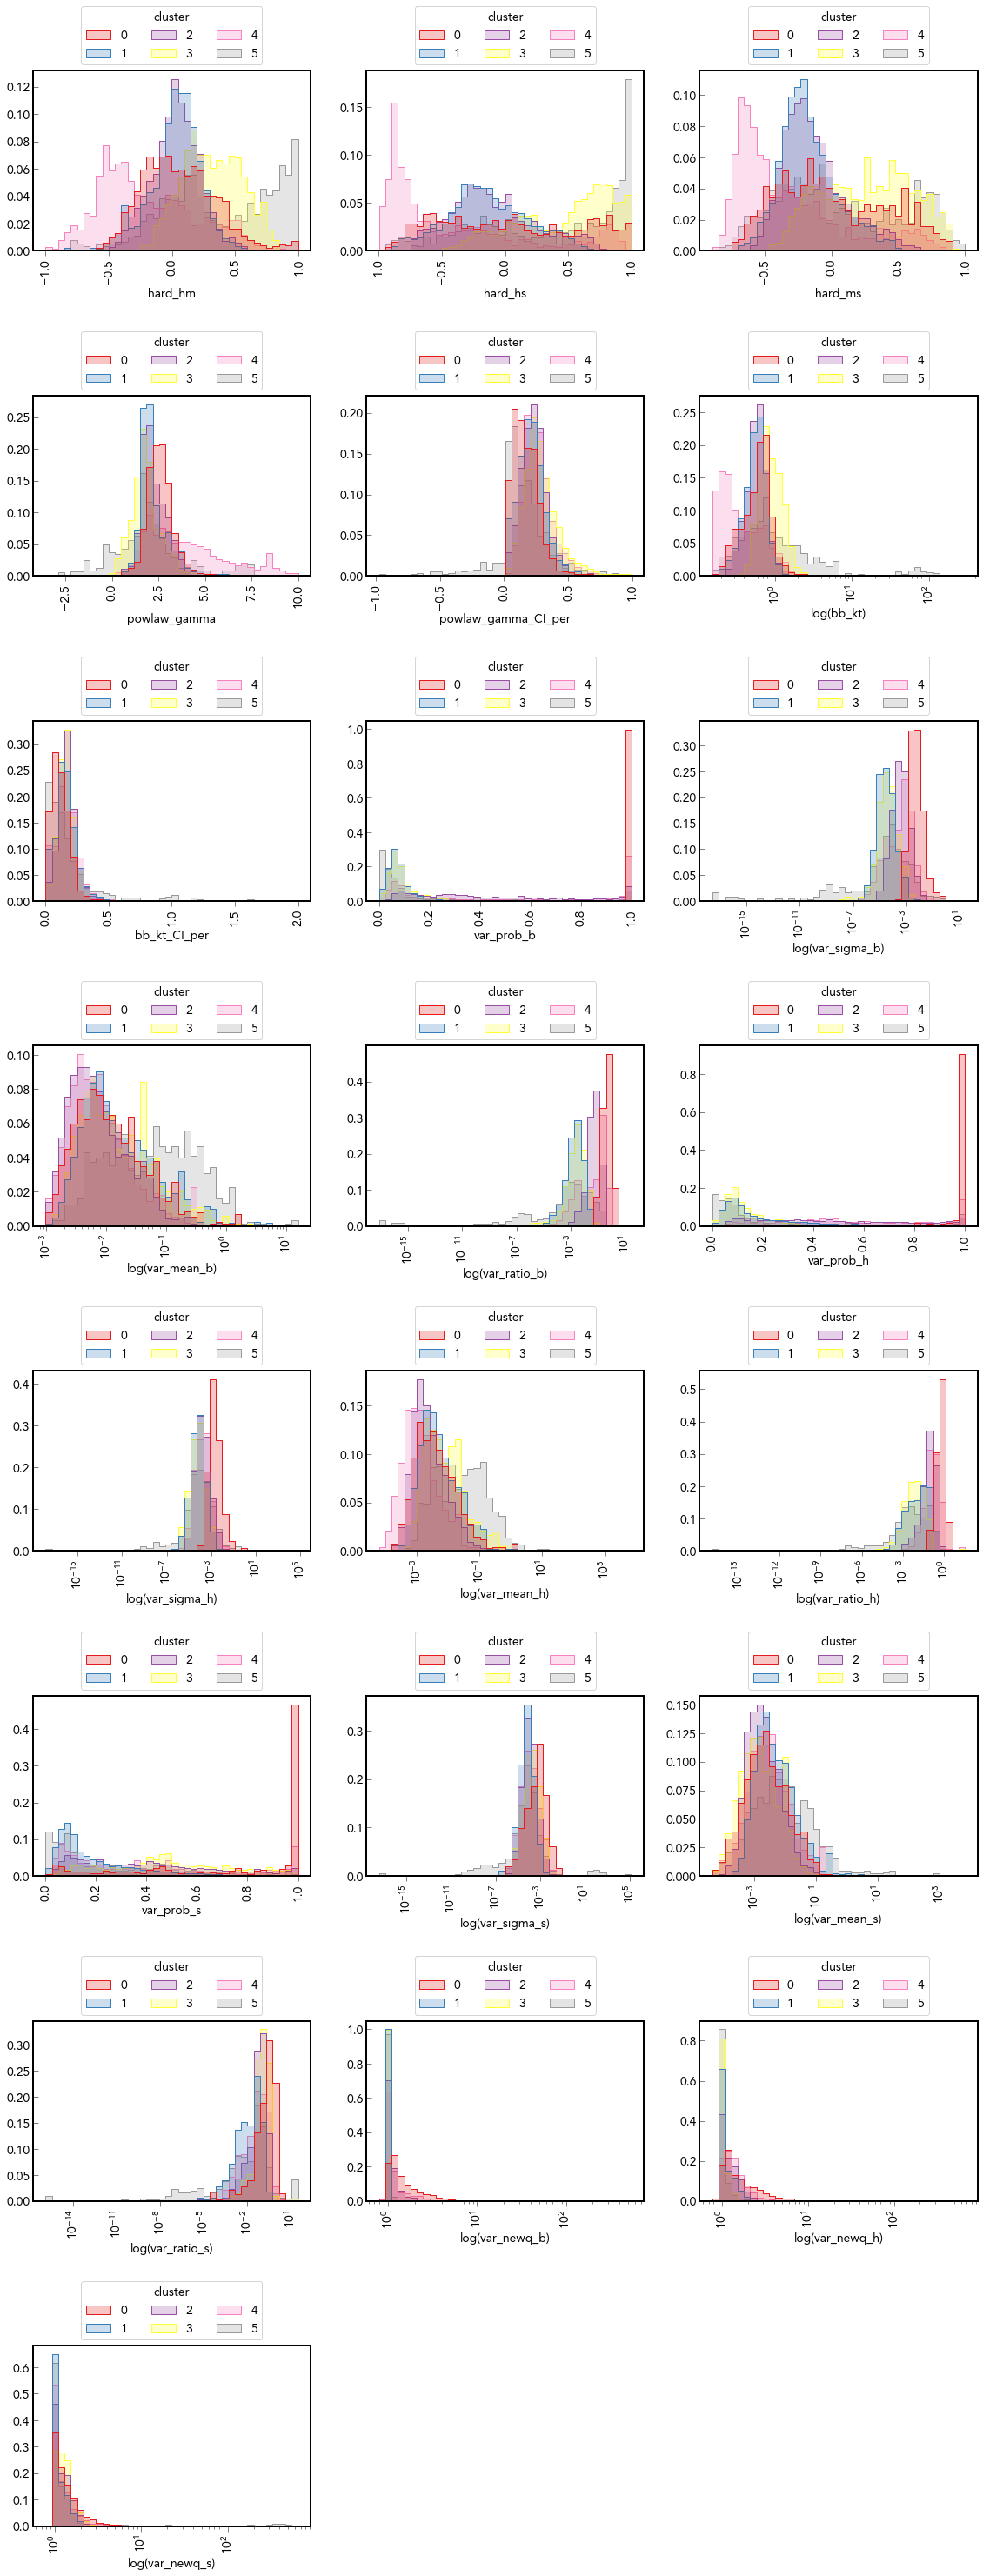

In [13]:
hist_plots(df_xray_plus)